C:\Users\tttho\AppData\Local\Temp/ipykernel_3488/3278810870.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       685
           1       0.58      0.69      0.63        70

    accuracy                           0.92       755
   macro avg       0.77      0.82      0.79       755
weighted avg       0.93      0.92      0.93       755

Confusion Matrix:
 [[650  35]
 [ 22  48]]


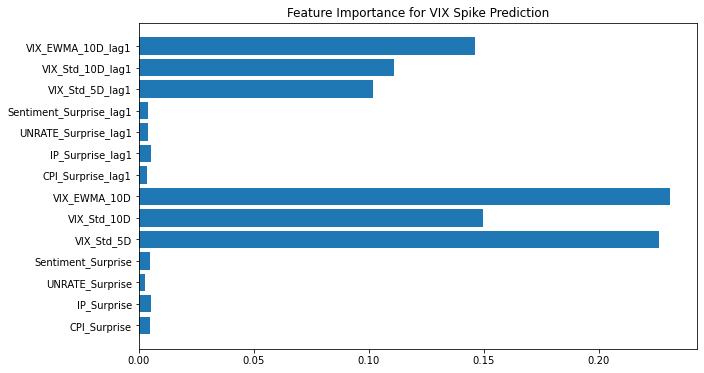

In [24]:
# =========================================
# Macro-Driven VIX Spike Prediction Starter
# =========================================

# Required packages
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Setup FRED API
# -----------------------------
fred_api_key = "f6f9b0c2da033808e90054312944b6c7"  # replace with your FRED API key
fred = Fred(api_key=fred_api_key)

# -----------------------------
# 2. Pull VIX Data
# -----------------------------
vix = yf.download("^VIX", start="2010-01-01", end="2025-01-01")

# Flatten MultiIndex columns if present
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Detect correct close column
for col in ['Close', 'Close_^VIX', 'Close_']:  # common possibilities
    if col in vix.columns:
        close_col = col
        break
else:
    raise KeyError(f"Cannot find a valid 'Close' column in VIX data. Columns: {vix.columns}")

vix = vix[[close_col]].rename(columns={close_col: 'VIX'})
vix['VIX_Return'] = vix['VIX'].pct_change()
vix.dropna(inplace=True)
vix.index = pd.to_datetime(vix.index)

# -----------------------------
# 3. Pull Macro Data from FRED
# -----------------------------
macro_series = {
    'UNRATE': 'Unemployment_Rate',
    'CPIAUCNS': 'CPI',
    'INDPRO': 'Industrial_Production',
    'UMCSENT': 'Consumer_Sentiment'
}

macro_data = pd.DataFrame()
for series_id, name in macro_series.items():
    df = fred.get_series(series_id, observation_start='2010-01-01')
    df = df.to_frame(name=name)
    df.index = pd.to_datetime(df.index)
    macro_data = pd.concat([macro_data, df], axis=1)

# Forward-fill monthly data to daily frequency
macro_data = macro_data.resample('D').ffill()

# -----------------------------
# 4. Merge VIX and Macro Data
# -----------------------------
data = vix.merge(macro_data, left_index=True, right_index=True, how='inner')

# -----------------------------
# 5. Create Macro "Surprises"
# -----------------------------
data['CPI_Surprise'] = data['CPI'].pct_change(1)
data['IP_Surprise'] = data['Industrial_Production'].pct_change(1)
data['UNRATE_Surprise'] = data['Unemployment_Rate'].diff(1)
data['Sentiment_Surprise'] = data['Consumer_Sentiment'].diff(1)

# -----------------------------
# 6. Define VIX Spike Target
# -----------------------------
threshold = data['VIX_Return'].quantile(0.9)
data['VIX_Spike'] = (data['VIX_Return'] > threshold).astype(int)

# -----------------------------
# 7. Feature Selection
# -----------------------------
features = ['CPI_Surprise', 'IP_Surprise', 'UNRATE_Surprise', 'Sentiment_Surprise']

# -----------------------------
# 7a. Add Rolling Volatility Features for VIX
# -----------------------------
data['VIX_Std_5D'] = data['VIX_Return'].rolling(5).std()
data['VIX_Std_10D'] = data['VIX_Return'].rolling(10).std()
features += ['VIX_Std_5D', 'VIX_Std_10D']

# -----------------------------
# 7b. Add EWMA Volatility Feature
# -----------------------------
data['VIX_EWMA_10D'] = data['VIX_Return'].ewm(span=10, adjust=False).std()
features.append('VIX_EWMA_10D')

# -----------------------------
# 7c. Add 1-Day Lag Features
# -----------------------------
lag_features = ['CPI_Surprise', 'IP_Surprise', 'UNRATE_Surprise', 'Sentiment_Surprise',
                'VIX_Std_5D', 'VIX_Std_10D', 'VIX_EWMA_10D']

for col in lag_features:
    data[f'{col}_lag1'] = data[col].shift(1)

features += [f'{col}_lag1' for col in lag_features]

# Recreate X with lagged features
X = data[features].fillna(0)
y = data['VIX_Spike']

# -----------------------------
# 8. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -----------------------------
# 9. Random Forest Classifier
# -----------------------------
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# -----------------------------
# 9a. Probabilistic Thresholding
# -----------------------------
# Predict probabilities
y_proba = clf.predict_proba(X_test)[:, 1]

# Set custom threshold
threshold_prob = 0.25
y_pred = (y_proba > threshold_prob).astype(int)

# -----------------------------
# 10. Evaluation
# -----------------------------
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance plot
importances = clf.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.title("Feature Importance for VIX Spike Prediction")
plt.show()

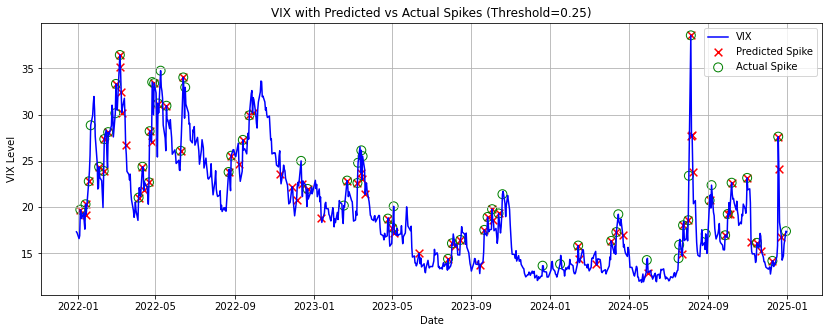

In [25]:
# =========================================
# Visualize Predicted VIX Spikes (with EWMA)
# =========================================

import matplotlib.pyplot as plt

# Select test portion of data
data_test = data.iloc[X_train.shape[0]:].copy()

# Predict probabilities using trained Random Forest
y_proba = clf.predict_proba(X_test)[:, 1]

# Apply your probabilistic threshold
threshold_prob = 0.25
data_test['Predicted_Spike'] = (y_proba > threshold_prob).astype(int)

# Ensure the index is 1D datetime for plotting
x_vals = pd.to_datetime(data_test.index).values
vix_vals = data_test['VIX'].values

# Optional: overlay actual spikes for comparison
actual_spike_vals = data_test['VIX_Spike'].values

plt.figure(figsize=(14,5))
plt.plot(x_vals, vix_vals, label='VIX', color='blue')

# Predicted spikes
plt.scatter(x_vals[data_test['Predicted_Spike']==1],
            vix_vals[data_test['Predicted_Spike']==1],
            color='red', label='Predicted Spike', marker='x', s=60)

# Actual spikes
plt.scatter(x_vals[data_test['VIX_Spike']==1],
            vix_vals[data_test['VIX_Spike']==1],
            facecolors='none', edgecolors='green', label='Actual Spike', marker='o', s=80)

plt.title(f"VIX with Predicted vs Actual Spikes (Threshold={threshold_prob})")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend()
plt.grid(True)
plt.show()